In [1]:
import atlite
import matplotlib.pyplot as plt
import math 
import numpy as np
import json 
import pickle
import os
import geopandas as gpd
from rasterio.plot import show  
from atlite.gis import shape_availability
import rasterio

In [2]:
region_name='Elbe-Elster'
EPSG_custom = ''

resampled = '_resampled'

dirname = os.getcwd() 
data_path = os.path.join(dirname, 'data', region_name)

# Load the json EPSG code for the country
with open(os.path.join(data_path, region_name+'_EPSG.pkl'), 'rb') as file:
        EPSG = pickle.load(file)
#use custom EPSG instead of local UTM zone if wanted
if EPSG_custom:
    EPSG=int(EPSG_custom)

print(f'EPSG {EPSG}')

landcoverPath=os.path.join(data_path, f'landcover_{region_name}_EPSG{EPSG}.tif')
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_EPSG{EPSG}{resampled}.tif')
slopeRasterPath = os.path.join(data_path, f'slope_{region_name}_EPSG{EPSG}{resampled}.tif')
regionPath =os.path.join(data_path, f'{region_name}_{EPSG}.geojson')
region = gpd.read_file(regionPath)

try:
     northfacingRasterPath = os.path.join(data_path, f'north_facing_{region_name}_EPSG{EPSG}{resampled}.tif')
except:
     print('no north-facing file')

try: 
    roadsPath = os.path.join(data_path, f'OSM_roads_{region_name}_{EPSG}.geojson')
except:
    print('no roads file')
try:
    railwaysPath = os.path.join(data_path, f'OSM_railways_{region_name}_{EPSG}.geojson')
except:
    print('no railways file')
try:
    airportsPath = os.path.join(data_path, f'OSM_airports_{region_name}_{EPSG}.geojson')
except:
    print('no airports file')

EPSG 32633


In [3]:
#load unique land use codes
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'r') as fp:
    landuses = json.load(fp)

#load pixel size
if not EPSG==4326:
    with open(os.path.join(data_path, f'pixel_size_{region_name}_{EPSG}.json'), 'r') as fp:
        res = json.load(fp)
else:
    res = 0.0009920634920634887558

print(landuses)
print(len(landuses))
print(res)

[20, 30, 40, 50, 80, 90, 111, 114, 115, 116, 121, 124, 125, 126, 255]
15
82.3505638195615


In [4]:
region.geometry.item().area/1e6 #km²

1898.5407012075332

# Testing data by exlcuding all land cover codes iteratively (in the end nothing should be available)

0 20
1 30
2 40
3 50
4 80
5 90
6 111
7 114
8 115
9 116
10 121
11 124
12 125
13 126
14 255


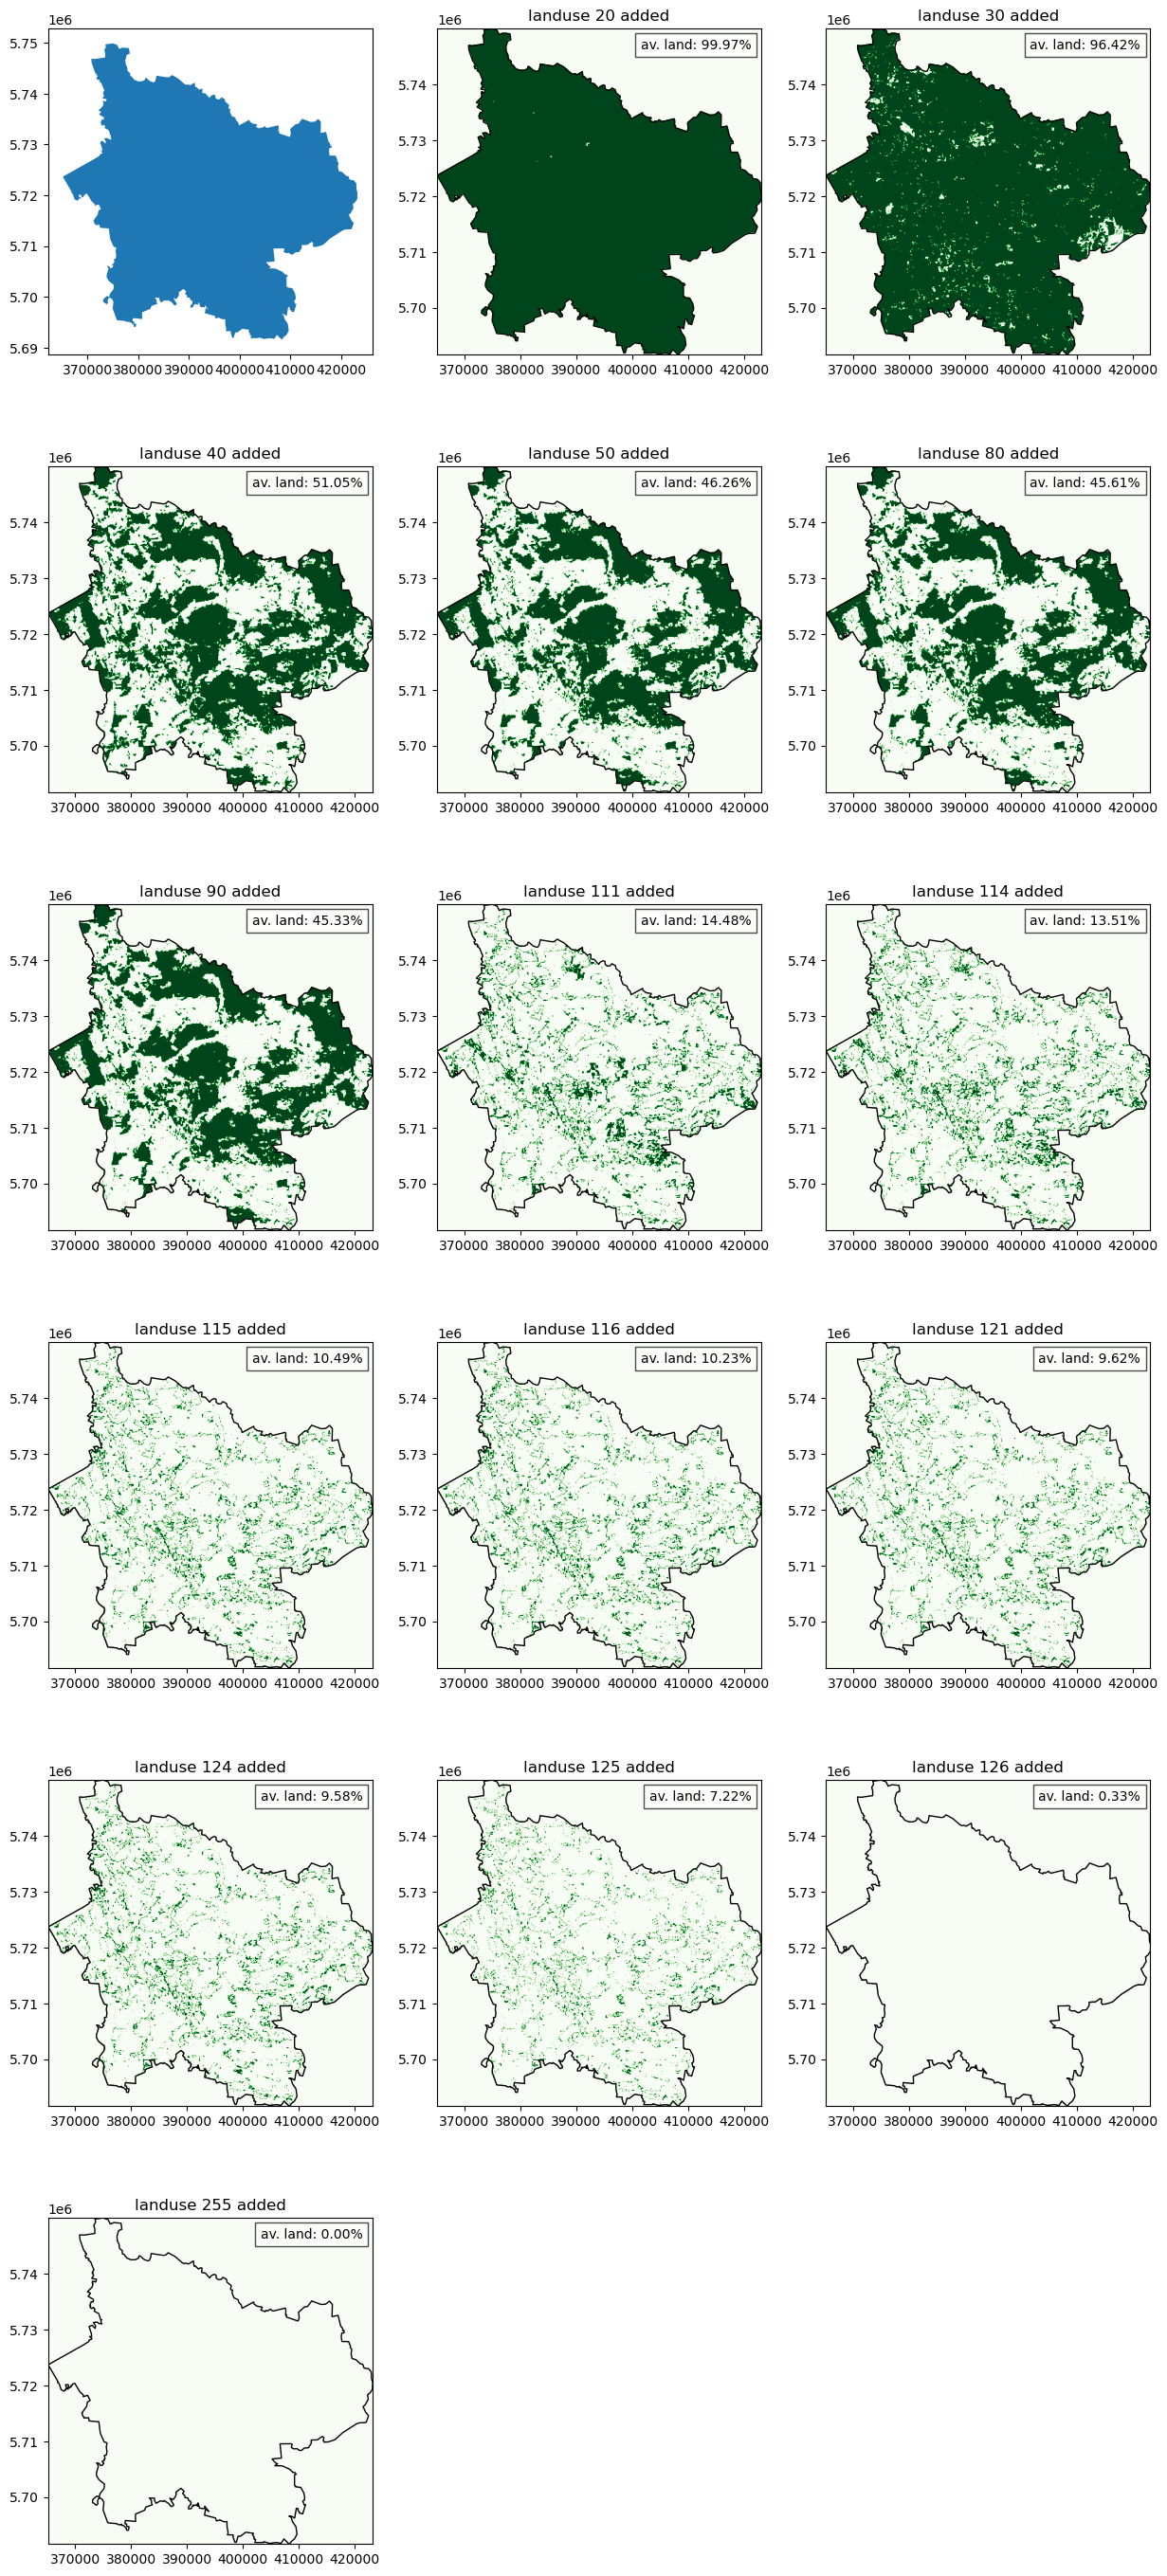

In [5]:
plt.figure(figsize=(15, 35))

#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#plot plain study region first, then add plots where land use codes where added iteratively in the loop
ax = plt.subplot(math.ceil((len(landuses)+1)/3), 3, 1)
region.plot(ax=ax)


# loop through the length of landuses and keep track of index n
for n, landuse in enumerate(landuses):
    print(n, landuse)

    # add a new subplot iteratively
    ax = plt.subplot(math.ceil((len(landuses)+1)/3), 3, n + 2)

    #add exclusion and plot
    excluder.add_raster(landcoverPath, codes=landuse,crs=EPSG)
    #calculate available areas
    masked, transform = shape_availability(region.geometry, excluder)
    #plot it
    region.plot(ax=ax, color="none")
    show(masked, transform=transform, cmap="Greens", ax=ax)
    ax.set_title(f'landuse {landuse} added')

    # calculate elible share
    eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area

    # Add text box to each subplot in top right corner
    ax.text(0.97, 0.97, f'av. land: {eligible_share:.2%}', 
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7))

# Set your exclusions

In [6]:
#initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=EPSG, res=res)

#add landcover exclusions
excluder.add_raster(landcoverPath, codes=[80,111,114,115,116],crs=EPSG)
excluder.add_raster(landcoverPath, codes=[50], buffer=1000 ,crs=EPSG)

#add elevation exclusions
excluder.add_raster(demRasterPath, codes=range(2000,10000), crs=EPSG)

#add slope exclusions
excluder.add_raster(slopeRasterPath, codes=range(20,90), crs=EPSG)

#add north facing exclusion
try:
    excluder.add_raster(northfacingRasterPath, codes=1, crs=EPSG)
except:
    pass

#add exclusions from vector data
excluder.add_geometry(railwaysPath, buffer=100)
excluder.add_geometry(roadsPath, buffer=100)
excluder.add_geometry(airportsPath, buffer=5000)

#calculate available areas
masked, transform = shape_availability(region.geometry, excluder)

eligible_share = masked.sum() * excluder.res**2 / region.geometry.item().area
print(f"The eligibility share is: {eligible_share:.2%}")

The eligibility share is: 14.75%


<Axes: title={'center': 'Eligible area (green) 14.75%'}>

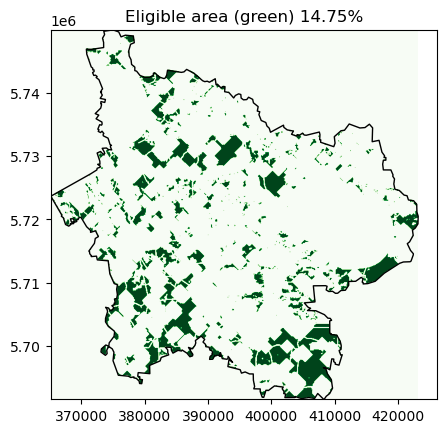

In [7]:
fig, ax = plt.subplots()
excluder.plot_shape_availability(region)

In [12]:
# Convert boolean array to integers (1 for True, 0 for False)
int_array = masked.astype(np.uint8)

# Set 0 (False) to be the nodata value
nodata_value = 0

#save eligible land array as .tif file
# Define the metadata for the new file
# You'll need to adjust these parameters based on your specific data
metadata = {
    'driver': 'GTiff',
    'dtype': rasterio.uint8,
    'nodata': nodata_value,
    'width': masked.shape[1],
    'height': masked.shape[0],
    'count': 1,
    'crs': rasterio.crs.CRS.from_epsg(EPSG),  # WGS84, modify as needed
    'transform': transform
}

# Write the array to a new .tif file
with rasterio.open(os.path.join(data_path, f'available_land_{region_name}_EPSG{EPSG}.tif'), 'w', **metadata) as dst:
    dst.write(masked, 1)